## POS tagging using modified Viterbi

###  Using the TreeBank universal tag set corpus, build a Viterbi PoS tagger, then enhance it to solve the problem of unknown words

### Data Preparation

In [1]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
# first few tagged sentences
print(nltk_data[:10])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [4]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.05)

print(len(train_set))
print(len(test_set))
print(train_set[:5])

3718
196
[[('The', 'DET'), ('Dow', 'NOUN'), ('Jones', 'NOUN'), ('Industrial', 'NOUN'), ('Average', 'NOUN'), (',', '.'), ('which', 'DET'), ('*T*-1', 'X'), ('had', 'VERB'), ('jumped', 'VERB'), ('41.60', 'NUM'), ('points', 'NOUN'), ('on', 'ADP'), ('Tuesday', 'NOUN'), (',', '.'), ('drifted', 'VERB'), ('on', 'ADP'), ('either', 'DET'), ('side', 'NOUN'), ('of', 'ADP'), ('its', 'PRON'), ('previous', 'ADJ'), ('close', 'NOUN'), ('and', 'CONJ'), ('finished', 'VERB'), ('with', 'ADP'), ('a', 'DET'), ('gain', 'NOUN'), ('of', 'ADP'), ('just', 'ADV'), ('0.82', 'NUM'), ('at', 'ADP'), ('2645.90', 'NUM'), ('.', '.')], [('Ballot', 'NOUN'), ('watchers', 'NOUN'), ('say', 'VERB'), ('0', 'X'), ('attention', 'NOUN'), ('already', 'ADV'), ('is', 'VERB'), ('focused', 'VERB'), ('*-1', 'X'), ('on', 'ADP'), ('the', 'DET'), ('1990', 'NUM'), ('elections', 'NOUN'), ('.', '.')], [('She', 'PRON'), ('took', 'VERB'), ('her', 'PRON'), ('business', 'NOUN'), ('to', 'PRT'), ('First', 'NOUN'), ('Atlanta', 'NOUN'), ('.', '.')], 

In [5]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95614

In [6]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['The',
 'Dow',
 'Jones',
 'Industrial',
 'Average',
 ',',
 'which',
 '*T*-1',
 'had',
 'jumped']

In [7]:
# vocabulary
V = set(tokens)
print(len(V))

12071


In [8]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [9]:
print(T)

{'X', 'NUM', 'ADJ', 'CONJ', 'PRT', 'NOUN', 'PRON', 'VERB', 'ADV', '.', 'DET', 'ADP'}


##  POS Tagging Algorithm - HMM
### Emission Probabilities

In [10]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [11]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

### Transition Probabilities

In [12]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [13]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [14]:
tags_matrix

array([[7.45746568e-02, 2.54412461e-03, 1.73318498e-02, 1.01764984e-02,
        1.83972016e-01, 6.23310544e-02, 5.56527264e-02, 2.04325005e-01,
        2.54412461e-02, 1.65050089e-01, 5.54937199e-02, 1.43107012e-01],
       [2.13713273e-01, 1.86405465e-01, 3.35411094e-02, 1.27634313e-02,
        2.46363916e-02, 3.52330059e-01, 1.48411992e-03, 1.78094395e-02,
        2.67141592e-03, 1.16058178e-01, 3.26506374e-03, 3.53220552e-02],
       [2.07441561e-02, 2.07441561e-02, 6.45373687e-02, 1.66282523e-02,
        1.02074416e-02, 7.00856090e-01, 6.58544595e-04, 1.16891665e-02,
        4.60981252e-03, 6.58544600e-02, 4.60981252e-03, 7.88607150e-02],
       [6.98649278e-03, 4.09874246e-02, 1.16441548e-01, 0.00000000e+00,
        4.65766201e-03, 3.47461581e-01, 5.86865395e-02, 1.59757808e-01,
        5.44946454e-02, 3.67955305e-02, 1.20633446e-01, 5.30973449e-02],
       [1.31233595e-02, 5.38057759e-02, 8.49737525e-02, 2.29658792e-03,
        1.64041994e-03, 2.48359576e-01, 1.90288723e-02, 4.01

In [15]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [16]:
tags_df

,X,NUM,ADJ,CONJ,PRT,NOUN,PRON,VERB,ADV,.,DET,ADP
X,0.074575,0.002544,0.017332,0.010176,0.183972,0.062331,0.055653,0.204325,0.025441,0.165050,0.055494,0.143107
NUM,0.213713,0.186405,0.033541,0.012763,0.024636,0.352330,0.001484,0.017809,0.002671,0.116058,0.003265,0.035322
ADJ,0.020744,0.020744,0.064537,0.016628,0.010207,0.700856,0.000659,0.011689,0.004610,0.065854,0.004610,0.078861
CONJ,0.006986,0.040987,0.116442,0.000000,0.004658,0.347462,0.058687,0.159758,0.054495,0.036796,0.120633,0.053097
PRT,0.013123,0.053806,0.084974,0.002297,0.001640,0.248360,0.019029,0.401247,0.010499,0.043307,0.100722,0.020997
NOUN,0.028897,0.009340,0.012077,0.042688,0.044075,0.264850,0.004853,0.146600,0.017331,0.239565,0.013354,0.176372
PRON,0.092055,0.007257,0.073720,0.004966,0.012605,0.207410,0.007257,0.487013,0.033995,0.040489,0.009931,0.023300
VERB,0.218107,0.022983,0.065145,0.005280,0.031447,0.109636,0.035639,0.168957,0.081916,0.034708,0.134948,0.091234
ADV,0.023125,0.032375,0.130823,0.006938,0.014536,0.031384,0.014536,0.341262,0.080278,0.137430,0.069045,0.118269
.,0.027059,0.080816,0.044408,0.058252,0.002337,0.221953,0.066793,0.088997,0.052589,0.092682,0.172959,0.091064


In [17]:
tags_df.loc['.', :]

X       0.027059
NUM     0.080816
ADJ     0.044408
CONJ    0.058252
PRT     0.002337
NOUN    0.221953
PRON    0.066793
VERB    0.088997
ADV     0.052589
.       0.092682
DET     0.172959
ADP     0.091064
Name: ., dtype: float32

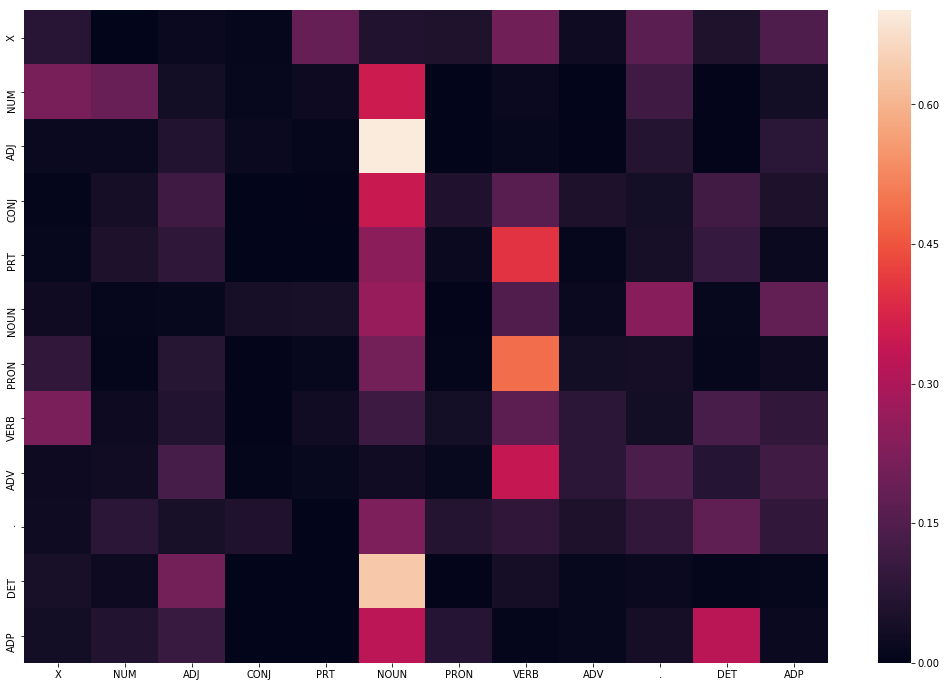

In [18]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()


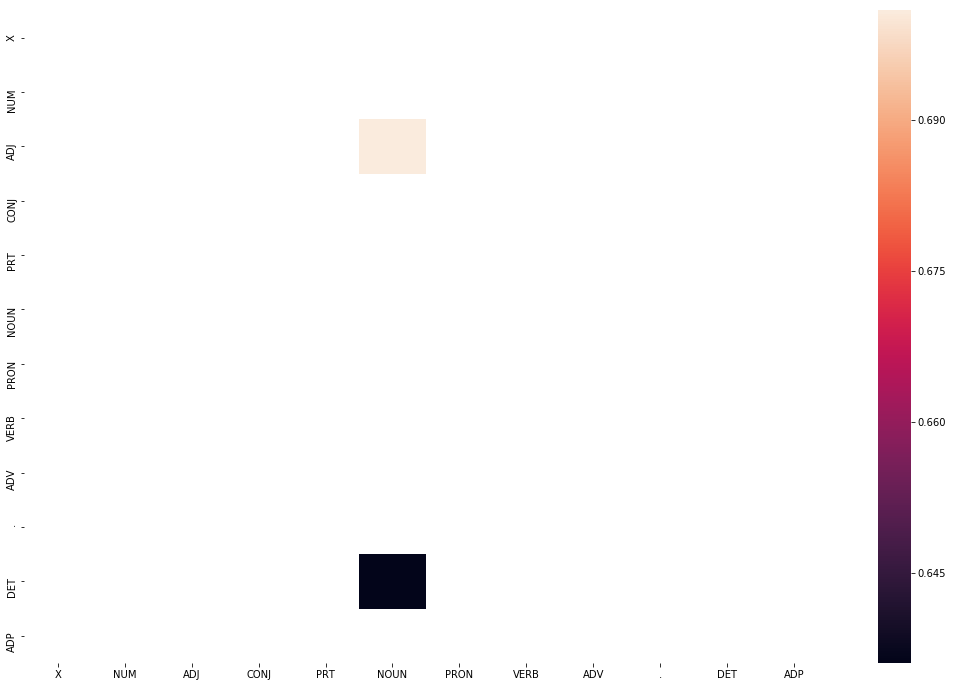

In [19]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

In [20]:
len(train_tagged_words)

95614

### Build the vanilla Viterbi based POS tagger

In [21]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [22]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('Mr.', 'NOUN'),
  ('Stern', 'NOUN'),
  ('was', 'VERB'),
  ('chairman', 'NOUN'),
  ('and', 'CONJ'),
  ('chief', 'NOUN'),
  ('executive', 'ADJ'),
  ('officer', 'NOUN'),
  ('of', 'ADP'),
  ('the', 'DET'),
  ('New', 'NOUN'),
  ('York', 'NOUN'),
  ('State', 'NOUN'),
  ('Urban', 'NOUN'),
  ('Development', 'NOUN'),
  ('Corp.', 'NOUN'),
  (',', '.'),
  ('1983-85', 'NUM'),
  ('.', '.')],
 [('The', 'DET'),
  ('department', 'NOUN'),
  ("'s", 'PRT'),
  ('Occupational', 'NOUN'),
  ('Safety', 'NOUN'),
  ('and', 'CONJ'),
  ('Health', 'NOUN'),
  ('Administration', 'NOUN'),
  ('proposed', 'VERB'),
  ('fines', 'NOUN'),
  ('of', 'ADP'),
  ('$', '.'),
  ('6.1', 'NUM'),
  ('million', 'NUM'),
  ('*U*', 'X'),
  ('for', 'ADP'),
  ('alleged', 'VERB'),
  ('violations', 'NOUN'),
  ('at', 'ADP'),
  ('the', 'DET'),
  ('company', 'NOUN'),
  ("'s", 'PRT'),
  ('Fairless', 'NOUN'),
  ('Hills', 'NOUN'),
  (',', '.'),
  ('Pa.', 'NOUN'),
  (',', '.'),
  ('steel', 'NOUN'),
  ('mill', 'NOUN'),
  (';', '.'),
  ('that', '

In [23]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [24]:
print("Time taken in seconds: ", difference)
print(tagged_seq)
#print(test_run_base)

Time taken in seconds:  19.62760853767395
[('Mr.', 'NOUN'), ('Stern', 'X'), ('was', 'VERB'), ('chairman', 'NOUN'), ('and', 'CONJ'), ('chief', 'NOUN'), ('executive', 'NOUN'), ('officer', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('New', 'NOUN'), ('York', 'NOUN'), ('State', 'NOUN'), ('Urban', 'X'), ('Development', 'NOUN'), ('Corp.', 'NOUN'), (',', '.'), ('1983-85', 'X'), ('.', '.'), ('The', 'DET'), ('department', 'NOUN'), ("'s", 'PRT'), ('Occupational', 'NOUN'), ('Safety', 'NOUN'), ('and', 'CONJ'), ('Health', 'NOUN'), ('Administration', 'NOUN'), ('proposed', 'VERB'), ('fines', 'NOUN'), ('of', 'ADP'), ('$', '.'), ('6.1', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('for', 'ADP'), ('alleged', 'ADJ'), ('violations', 'NOUN'), ('at', 'ADP'), ('the', 'DET'), ('company', 'NOUN'), ("'s", 'PRT'), ('Fairless', 'NOUN'), ('Hills', 'NOUN'), (',', '.'), ('Pa.', 'NOUN'), (',', '.'), ('steel', 'NOUN'), ('mill', 'X'), (';', '.'), ('that', 'DET'), ('was', 'VERB'), ('a', 'DET'), ('record', 'NOUN'), ('for', 'AD

In [25]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j]
accuracy_vanilla_viterbi = len(check)/len(tagged_seq)
accuracy_vanilla_viterbi

0.9134615384615384

In [26]:
incorrect_tagged_vanilla_viterbi = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_vanilla_viterbi

[[('Mr.', 'NOUN'), (('Stern', 'X'), ('Stern', 'NOUN'))],
 [('chief', 'NOUN'), (('executive', 'NOUN'), ('executive', 'ADJ'))],
 [('State', 'NOUN'), (('Urban', 'X'), ('Urban', 'NOUN'))],
 [(',', '.'), (('1983-85', 'X'), ('1983-85', 'NUM'))],
 [('for', 'ADP'), (('alleged', 'ADJ'), ('alleged', 'VERB'))],
 [('steel', 'NOUN'), (('mill', 'X'), ('mill', 'NOUN'))],
 [('-LRB-', '.'), (('Fewer', 'X'), ('Fewer', 'ADJ'))],
 [('benefit', 'VERB'), (('agriculture', 'X'), ('agriculture', 'NOUN'))],
 [('also', 'ADV'), (('works', 'NOUN'), ('works', 'VERB'))]]

In [27]:
## Testing
sentence_test = 'Google and Twitter made a deal in 2015 that gave Google access to Twitter\'s firehose.'
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start

In [28]:
print(tagged_seq)
print(difference)

[('Google', 'X'), ('and', 'CONJ'), ('Twitter', 'X'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'X'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'X'), ("'s", 'PRT'), ('firehose', 'X'), ('.', '.')]
3.2278506755828857


### Solve the problem of unknown words

1. Use lexical techniqies on the same data to see if we get better <br>
2. Use these to tag unknown words, then see if we get better.  



Start with unigram tagger

In [29]:
# Lexicon (or unigram tagger)
unigram_tagger = nltk.UnigramTagger(train_set)
accuracy_unigram_tagger = unigram_tagger.evaluate(test_set)
print(accuracy_unigram_tagger)

0.9051758198340577


In [30]:
# specify patterns for tagging
# example from the NLTK book
patterns = [
    (r'.*ing$', 'VBG'),              # gerund
    (r'.*ed$', 'VBD'),               # past tense
    (r'.*es$', 'VBZ'),               # 3rd singular present
    (r'.*ould$', 'MD'),              # modals
    (r'.*\'s$', 'NN$'),              # possessive nouns
    (r'.*s$', 'NNS'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'CD'), # cardinal numbers
    (r'.*', 'NN')                    # nouns
]


In [31]:
# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

# lexicon backed up by the rule-based tagger
lexicon_tagger = nltk.UnigramTagger(train_set, backoff=rule_based_tagger)

accuracy_lexicon_tagger = lexicon_tagger.evaluate(test_set)
print(accuracy_lexicon_tagger)

0.9051758198340577


Trigram tagger

In [32]:
# Bigram and Trigram tagger
bigram_tagger = nltk.BigramTagger(train_set,backoff=lexicon_tagger)
bigram_tagger.evaluate(test_set)
accuracy_bigram_tagger = bigram_tagger.evaluate(test_set)
print(accuracy_bigram_tagger)

0.9091268273409719


In [33]:
trigram_tagger = nltk.TrigramTagger(train_set, backoff=bigram_tagger)
trigram_tagger.evaluate(test_set)
accuracy_trigram_tagger = trigram_tagger.evaluate(test_set)
print(accuracy_trigram_tagger)

0.9091268273409719


Getting marginally better, but not by much. <br>
Next lets see if we can use this for the unknown words 


Now to build this into viterbi, need to change the regex patterns to fit for the tags in our data (NOUN instead of NNS etc)  

In [34]:
print(T)

{'X', 'NUM', 'ADJ', 'CONJ', 'PRT', 'NOUN', 'PRON', 'VERB', 'ADV', '.', 'DET', 'ADP'}


In [35]:
def trigram_tagger(word,train_set = train_set):
    patterns1 = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense
    (r'.*es$', 'VERB'),               # 3rd singular present
    (r'.*ould$', 'X'),              # modals
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'.*', 'NOUN')                    # nouns
    ]
    regex_based_tagger = nltk.RegexpTagger(patterns1)

    # trigram backed up by the regex tagger
    trigram_regex_tagger = nltk.TrigramTagger(train_set, backoff=regex_based_tagger)
    return trigram_regex_tagger.tag_sents([[(word)]])

In [36]:
# viterbi with handling for unknown words from regex tagger

def Viterbi_modified(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        # unknown words from trigram taggr
        if word not in tokens:
            unk_word_tag=trigram_tagger(word)
            for sent in unk_word_tag:
                for tup in sent:
                    state.append(tup[1])
        # rest remains same            
        else:            
            p = [] 
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
            
    return list(zip(words, state))

In [37]:
start = time.time()
tagged_seq = Viterbi_modified(test_tagged_words)
end = time.time()
difference = end-start

#### Evaluating tagging accuracy

In [38]:

test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_tagged_words

['Mr.',
 'Stern',
 'was',
 'chairman',
 'and',
 'chief',
 'executive',
 'officer',
 'of',
 'the',
 'New',
 'York',
 'State',
 'Urban',
 'Development',
 'Corp.',
 ',',
 '1983-85',
 '.',
 'The',
 'department',
 "'s",
 'Occupational',
 'Safety',
 'and',
 'Health',
 'Administration',
 'proposed',
 'fines',
 'of',
 '$',
 '6.1',
 'million',
 '*U*',
 'for',
 'alleged',
 'violations',
 'at',
 'the',
 'company',
 "'s",
 'Fairless',
 'Hills',
 ',',
 'Pa.',
 ',',
 'steel',
 'mill',
 ';',
 'that',
 'was',
 'a',
 'record',
 'for',
 'proposed',
 'penalties',
 'at',
 'any',
 'single',
 'facility',
 '.',
 '-LRB-',
 'Fewer',
 'said',
 '0',
 'conditions',
 'wo',
 "n't",
 'change',
 '.',
 '-RRB-',
 '``',
 'All',
 'of',
 'these',
 'forces',
 'came',
 'together',
 'in',
 '1988',
 '*',
 'to',
 'benefit',
 'agriculture',
 ',',
 "''",
 'Mr.',
 'Collins',
 'said',
 '*T*-1',
 '.',
 'His',
 'wife',
 'also',
 'works',
 'for',
 'the',
 'paper',
 ',',
 'as',
 'did',
 'his',
 'father',
 '.']

In [39]:
# tagging the test sentences
start = time.time()
tagged_seq_modified = Viterbi_modified(test_tagged_words)
end = time.time()
difference = end-start

In [40]:
print("Time taken in seconds: ", difference)
print(tagged_seq_modified)
#print(test_run_base)

Time taken in seconds:  30.6696298122406
[('Mr.', 'NOUN'), ('Stern', 'NOUN'), ('was', 'VERB'), ('chairman', 'NOUN'), ('and', 'CONJ'), ('chief', 'NOUN'), ('executive', 'NOUN'), ('officer', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('New', 'NOUN'), ('York', 'NOUN'), ('State', 'NOUN'), ('Urban', 'NOUN'), ('Development', 'NOUN'), ('Corp.', 'NOUN'), (',', '.'), ('1983-85', 'NUM'), ('.', '.'), ('The', 'DET'), ('department', 'NOUN'), ("'s", 'PRT'), ('Occupational', 'NOUN'), ('Safety', 'NOUN'), ('and', 'CONJ'), ('Health', 'NOUN'), ('Administration', 'NOUN'), ('proposed', 'VERB'), ('fines', 'NOUN'), ('of', 'ADP'), ('$', '.'), ('6.1', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('for', 'ADP'), ('alleged', 'ADJ'), ('violations', 'NOUN'), ('at', 'ADP'), ('the', 'DET'), ('company', 'NOUN'), ("'s", 'PRT'), ('Fairless', 'NOUN'), ('Hills', 'NOUN'), (',', '.'), ('Pa.', 'NOUN'), (',', '.'), ('steel', 'NOUN'), ('mill', 'NOUN'), (';', '.'), ('that', 'DET'), ('was', 'VERB'), ('a', 'DET'), ('record', 'NOUN'), (

In [41]:
# accuracy
check1 = [i for i, j in zip(tagged_seq_modified, test_run_base) if i == j]
accuracy_viterbi_modified = len(check1)/len(tagged_seq_modified)
accuracy_viterbi_modified

0.9615384615384616

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [42]:
print(accuracy_vanilla_viterbi)

0.9134615384615384


In [43]:
print(accuracy_unigram_tagger)

0.9051758198340577


In [44]:
print(accuracy_bigram_tagger)

0.9091268273409719


In [45]:
print(accuracy_lexicon_tagger)

0.9051758198340577


In [46]:
print(accuracy_viterbi_modified)

0.9615384615384616


### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [47]:
## Testing
sentence_test1 = 'Google and Twitter made a deal in 2015 that gave Google access to Twitter\'s firehose.'
words = word_tokenize(sentence_test1)
tagged_seq = Viterbi(words)
print(tagged_seq)

[('Google', 'X'), ('and', 'CONJ'), ('Twitter', 'X'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'X'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'X'), ("'s", 'PRT'), ('firehose', 'X'), ('.', '.')]


In [48]:
tagged_seq_modified = Viterbi_modified(words)
print(tagged_seq_modified)

[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.')]


In [49]:
sentence_test2='Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.'
words = word_tokenize(sentence_test2)
tagged_seq = Viterbi(words)
print(tagged_seq)

[('Android', 'X'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'X'), ('worldwide', 'X'), ('on', 'ADP'), ('smartphones', 'X'), ('since', 'ADP'), ('2011', 'X'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'X'), ('.', '.')]


In [50]:
tagged_seq_modified = Viterbi_modified(words)
print(tagged_seq_modified)

[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]


In [51]:
sentence_test3='I Instagrammed a Facebook post taken from Android smartphone and uploaded results to Youtube.'
words = word_tokenize(sentence_test3)
tagged_seq = Viterbi(words)
print(tagged_seq)

[('I', 'PRON'), ('Instagrammed', 'X'), ('a', 'DET'), ('Facebook', 'X'), ('post', 'VERB'), ('taken', 'VERB'), ('from', 'ADP'), ('Android', 'X'), ('smartphone', 'X'), ('and', 'CONJ'), ('uploaded', 'X'), ('results', 'NOUN'), ('to', 'PRT'), ('Youtube', 'X'), ('.', '.')]


In [52]:
tagged_seq_modified = Viterbi_modified(words)
print(tagged_seq_modified)

[('I', 'PRON'), ('Instagrammed', 'VERB'), ('a', 'DET'), ('Facebook', 'NOUN'), ('post', 'NOUN'), ('taken', 'VERB'), ('from', 'ADP'), ('Android', 'NOUN'), ('smartphone', 'NOUN'), ('and', 'CONJ'), ('uploaded', 'VERB'), ('results', 'NOUN'), ('to', 'PRT'), ('Youtube', 'NOUN'), ('.', '.')]


We see the new words - Youtube, Facebook, smartphone going from X to NOUN. We alse see the verb of Instagrammed,uploaded getting recognised correctly